In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import tidynamics as tid
import os

from copy import deepcopy
from time import time
from numba import njit

In [68]:
class Polymer:
    
    def __init__(self,
                 r_beed:            float   = 1.0,
                 q_beed:            float   = 2.08,
                 bonds:             list    = None,
                 mobility:          float   = 0.002,
                 force_constant_nn: float   = 100.0,
                 epsilon_LJ:        float   = 0.25,
                 sigma_LJ:          float   = 2.0,
                 cutoff_LJ:         float   = 2.0,
                 lB_debye:          float   = 3.077,
                 c_S:               float   = 10,
                 cutoff_debye:      float   = 4.0,
                 pbc:               bool    = True,
                 box_length:        float   = None,
                 cwd:               str     = "/home/jan/Documents/masterthesis/project/mucus"):
    
        self.r_beed             = r_beed
        self.q_beed             = q_beed
        self.mobility           = mobility
        self.force_constant_nn  = force_constant_nn
        self.epsilon_LJ         = epsilon_LJ
        self.sigma_LJ           = sigma_LJ
        self.cutoff_LJ          = cutoff_LJ
        self.lB_debye           = lB_debye # units of beed radii
        self.c_S                = c_S # salt concentration [c_S] = mM
        self.cutoff_debye       = cutoff_debye
        self.cutoff_pbc         = cutoff_debye # NOTE here the debye cutoff is used since it is the force with the longest range
        self.pbc                = pbc
        self.bonds              = bonds
        self.cwd                = cwd       
        
        self.r0_beeds           = 2*r_beed
        self.A_debye            = self.q_beed**2*self.lB_debye
        self.B_debye            = 1/(r_beed*38.46153*self.c_S) # 1/(debye screening length) in units of beed radius            
        
    # TODO: make all variables "None" and initialize in methods
        self.n_beeds                = None
        self.box_length             = None
        self.shifts                 = None
        self.positions              = None
        self.forces                 = None
        self.energy                 = None
        self.trajectory             = None
        self.distances_bonded       = list(())
        self.directions_bonded      = list(())
        self.distances              = None
        self.directions             = None
        self.cm_trajectory          = None
        self.msd                    = None
        self.structure_factor       = None
        self.indices                = None
        self.idx_table              = None
        self.idx_interactions       = None
        
        
    # TODO: redo the get_bonds() method so that every bond pair only exists once
    
    def create_chain(self,
                     N = 10, 
                     axis: int = 0):
        """
        Create linear chain along specified axis, centered in the origin.
        The get_bonds() method is called here automatically.
        
        Arguments:
            axis (int): specify on which axis the chain lies on (0,1,2) -> (x,y,z)
        """
        self.n_beeds = N
        self.box_length = 2*self.r0_beeds*self.n_beeds
        
        self.positions = np.zeros((self.n_beeds, 3))
        
        for k in range(self.n_beeds):
            self.positions[k, axis] = k*self.r0_beeds
        
        #center chain around 0
        if self.n_beeds != 1:
            self.positions[:, axis] -= self.r0_beeds*(self.n_beeds-1)/2
        
        # create index list
        self.indices = np.arange(self.n_beeds)
        
        # create nxn index table 
        self.idx_table = np.zeros((2, self.n_beeds, self.n_beeds), dtype=int)
        for i in range(self.n_beeds):
            for j in range(self.n_beeds):
                self.idx_table[0, i, j] = i
                self.idx_table[1, i, j] = j

        self.positions += np.array((self.box_length/2, self.box_length/2, self.box_length/2)) 
        
        # set first trajecory frame to initial position
        self.trajectory = np.zeros((1, self.n_beeds, 3)) # first dim is the frame
        self.trajectory[0,:,:] = deepcopy(self.positions)
        
        self.create_shifts()
        self.apply_pbc()
        self.get_bonds()
        
        return
    
    
    def create_box(self, N=10, M=5, r0=2, L=None):
        # create box with M chains consisting of N atoms
        
        self.n_beeds = N*M
        
        if M == 1:
            self.create_chain(N=N*M)
            return
        
        if L is None:
            L = N*r0 # box length

        self.box_length = L
        
        n_row = int(np.round(np.sqrt(M)))

        # check how many cols are needed
        n_col = 0
        while n_col*n_row < M:
            n_col += 1

        d_row = L/(n_row+1)
        d_col = L/(n_col+1)

        positions = np.zeros((M*N, 3))
        bonds = list(())

        particle_idx = 0
        # make centered mesh
        for i in range(n_col):
            for j in range(n_row):
                if particle_idx == N*M:
                    break
                # create chain
                n = 0
                for k in range(particle_idx, N+particle_idx):
                    positions[k, (i+1)%2] = (L-r0*(N-1))/2 + n*r0
                    positions[k, i%2] = j*d_row + d_row 
                    positions[k, 2] = i*d_col + d_col 
                    n += 1
                # add bonds to bond list
                bonds.append((particle_idx, particle_idx+1))
                for k in range(N-2):
                    particle_idx += 1
                    bonds.append((particle_idx, particle_idx-1))
                    bonds.append((particle_idx, particle_idx+1))
                particle_idx += 1
                bonds.append((particle_idx, particle_idx-1))
                particle_idx += 1
                
        self.positions = deepcopy(positions)
        self.bonds = np.array(bonds)
        
        self.trajectory = np.zeros((1, self.n_beeds, 3))
        self.trajectory[0,:,:] = deepcopy(self.positions)
        
        # create index list
        self.indices = np.arange(self.n_beeds)
        
        # create nxn index table 
        self.idx_table = np.zeros((2, self.n_beeds, self.n_beeds), dtype=int)
        for i in range(self.n_beeds):
            for j in range(self.n_beeds):
                self.idx_table[0, i, j] = i
                self.idx_table[1, i, j] = j
        
        self.create_shifts()
        self.apply_pbc() # unnecessary but feels wrong not to do it
        
        return
    
    def create_shifts(self):
        # array that shifts box for pbc
        self.shifts = np.array(((self.box_length,   0,                0),
                                (0,                 self.box_length,  0),
                                (0,            0,                     self.box_length),
                                (self.box_length,   self.box_length,  0),
                                (self.box_length,   0,                self.box_length),
                                (0,                 self.box_length,  self.box_length),
                                (self.box_length,   self.box_length,  self.box_length),
                                (-self.box_length,  0,                0),
                                (0,                -self.box_length,  0),
                                (0,            0,                    -self.box_length),
                                (-self.box_length,  self.box_length,  0),
                                (-self.box_length,  0,                self.box_length),
                                (0,                -self.box_length,  self.box_length),
                                (self.box_length,  -self.box_length,  0),
                                (self.box_length,   0,               -self.box_length),
                                (0,                 self.box_length, -self.box_length),
                                (-self.box_length, -self.box_length,  0),
                                (-self.box_length,  0,               -self.box_length),
                                (0,                -self.box_length, -self.box_length),
                                (-self.box_length,  self.box_length,  self.box_length),
                                (self.box_length,  -self.box_length,  self.box_length),
                                (self.box_length,   self.box_length, -self.box_length),
                                (-self.box_length, -self.box_length,  self.box_length),
                                (-self.box_length,  self.box_length, -self.box_length),
                                (self.box_length,  -self.box_length, -self.box_length),
                                (-self.box_length, -self.box_length, -self.box_length)))
        return
    
    def create_test_chain(self, 
                          sigma: float = 0.05, 
                          axis: int = 0,
                          centered = False):
        """
        Create linear chain along specified axis, centered in the origin.
        The positions of the linear chain are deviated wit a gaussian noise 
        of standard deviation sigma.
        The get_bonds() method is called here automatically.
        
        Arguments:
            sigma (float): standard deviation for the displacement
            axis (int): specify on which axis the chain lies on (0,1,2) -> (x,y,z)
        """
        if centered == True:
            axis = 0
        
        self.positions = np.zeros((self.n_beeds, 3))
        
        for k in range(self.n_beeds):
            self.positions[k, axis] = k*self.r0_beeds
        
        #center chain around 0
        if self.n_beeds != 1:
            self.positions[:, axis] -= self.r0_beeds*(self.n_beeds-1)/2
        
        if centered == True:   
            self.positions += np.array((self.box_length/2, self.box_length/2, self.box_length/2))
        else:
            self.positions[:, 1] += self.box_length/2
            self.positions[:, 2] += self.box_length/2
        
        # create index list
        self.indices = np.arange(self.n_beeds)
        
        # create nxn index table 
        self.idx_table = np.zeros((2, self.n_beeds, self.n_beeds), dtype=int)
        for i in range(self.n_beeds):
            for j in range(self.n_beeds):
                self.idx_table[0, i, j] = i
                self.idx_table[1, i, j] = j
        
        # to test forces
        self.positions += np.random.randn(self.n_beeds, 3)*sigma

        # set first trajecory frame to initial position
        self.trajectory[0,:,:] = deepcopy(self.positions)
        
        self.apply_pbc()
        self.get_bonds()
        
        return
    
    def get_bonds(self):
        """
        Create list of bond pair indices. 
        Bonds are saved twice, i.e.: (..., (i, j), ... , (j, i), ...)
        """
        #define bonds
        if self.bonds is None: 
            # if bonds are not already defined, create chain
            self.bonds =list(())
            self.bonds.append((0,1))
            for k in range(1, self.n_beeds-1):
                self.bonds.append((k, k-1))
                self.bonds.append((k, k+1))
            self.bonds.append((self.n_beeds-1, self.n_beeds-2))
            
            self.bonds = np.array(self.bonds)
        
        # calculate distances and directions for every bond tuple
        self.get_distances_directions()
        
        return
    
    def get_distances_directions(self):
        """
        Get distances and directions for every combination of atom within a certain cutoff distance to each other.
        The directions are not normalized, since the normalization happens in the forcefiled calculation.
        A list of index tuples is also calculated to assign the interactions to the specific atoms.
        """
        
        directions, distances, idx_table = self.dist_dir_box()
        
        # calculate dist dir for box edge w.r.t. cutoff
        directions_edges, distances_edges, idx_table_edges = self.dist_dir_edges()

        # check if there are edge interactions
        if idx_table_edges.size == 0:
            # if there are no edge interactions only use the values of the box
            self.directions = deepcopy(directions)
            self.distances = deepcopy(distances)
            self.idx_interactions = idx_table.T
        else:
            # combine dist/dir to one list
            self.directions = np.append(directions, directions_edges, axis=0)
            self.distances = np.append(distances, distances_edges, axis=0)
            self.idx_interactions = np.append(idx_table, idx_table_edges, axis=1).T
        
        
        return
    
    def dist_dir_edges(self):
        """
        This uses the concept of the "inner-" and "outer edge". Particles are defined to lie in the inner edge, 
        when thethey are inside the box within the a cutoff distance to the edge of the box. Similarly outer edges
        are particles, that are outside of the box within a cutoff distance to the box edge.
        
        This function calculates all the distances and directions of particles in the inner edge w.r.t. particles 
        in the outer edge and the filters out only particlies which lie in a cutoff distance towards each other.
        """

        # 3d logical lists
        L_left = self.positions < self.cutoff_pbc
        L_right = self.positions > (self.box_length-self.cutoff_pbc)

        #indexes all atoms inside the inner edge
        L_in = np.logical_or(np.sum(L_left, axis=1, dtype=bool), np.sum(L_right, axis=1, dtype=bool))

        edges_in = self.positions[L_in]
        edges_in_indices = self.indices[L_in]

        # only continue if there are edges_in 
        if edges_in_indices.size != 0:
            # shift system and append to array
            edges_out = self.positions + self.shifts[0]
            edges_out_indices = np.arange(self.n_beeds) # NOTE maybe use deepcopy instead? idk what is faster
            for shift in self.shifts[1:]:
                edges_out = np.append(edges_out, self.positions+shift, axis=0)
                edges_out_indices = np.append(edges_out_indices, self.indices)

            # check which particles lie in the outer edge
            L_left_out = np.logical_and((edges_out < 0), (edges_out >= -self.cutoff_pbc))
            L_right_out = np.logical_and((edges_out >= self.box_length), (edges_out < (self.box_length+self.cutoff_pbc)))
            L_out = np.logical_or(np.sum(L_left_out, axis=1, dtype=bool), np.sum(L_right_out, axis=1, dtype=bool))

            edges_out = edges_out[L_out]
            edges_out_indices = edges_out_indices[L_out]
            
            # only continue if there are edges_out
            if edges_out_indices.size != 0:
                # create distance matrix for edges in/out
                n_in = len(edges_in_indices)
                n_out = len(edges_out_indices)

                # create mesh of vectors
                A_mesh = np.tile(edges_in, (n_out, 1, 1)) # repeats vector along third dimension len(b) times
                B_mesh = np.reshape(np.repeat(edges_out, n_in, 0), (n_out, n_in, 3)) # does the same but "flipped"

                directions_edges = B_mesh-A_mesh
                distances_edges = np.linalg.norm(directions_edges, axis=2)

                idx_in, idx_out = np.meshgrid(edges_in_indices, edges_out_indices)
                idx_table_edges = np.append([idx_in], [idx_out], axis=0)
                
                # only output distances smaller than  cutoff
                L_edges = distances_edges < self.cutoff_pbc

                dirs = directions_edges[L_edges]
                dists = distances_edges[L_edges]
                idxs = idx_table_edges[:, L_edges]
                
            # if there are no interactions in the edges, output dummy variables since these are not used anyways
            else:
                dirs = np.array(())
                dists = np.array(())
                idxs = np.array(())
        else:
            dirs = np.array(())
            dists = np.array(())
            idxs = np.array(())
        
        return dirs, dists, idxs
    
    def dist_dir_box(self):
        """
        Calculates all the distances and directions of atoms that are distanced with a certain cutoff radius.
        
        Returns a list of unnormalized directions, a list of distances and a list of atom index tuples w.r.t
        the self.positions variable
        """
    
        # TODO could be faster by only calculating triu matrix

        # make 3d verion of meshgrid
        r_left = np.tile(self.positions, (self.n_beeds, 1, 1)) # repeats vector along third dimension len(a) times
        r_right = np.reshape(np.repeat(self.positions, self.n_beeds, 0), (self.n_beeds, self.n_beeds, 3)) # does the same but "flipped"

        directions = r_left - r_right # this is right considering the mesh method. dir[i, j] = r_j - r_i
        distances = np.linalg.norm(directions, axis=2)
        
        # use cutoff to index values 
        # NOTE this could probably be done in a smarter way
        distances += self.cutoff_pbc*np.eye(self.n_beeds) # add cutoff to disregard same atoms

        L_box = distances < self.cutoff_pbc # NOTE the "<" is important, because if it was "<=" the diagonal values would be included
        
        dirs = directions[L_box]
        dists = distances[L_box]
        idxs = self.idx_table[:, L_box]
        
        return dirs, dists, idxs

    def get_forces(self):
        """
        Delete all old forces and add all forces occuring in resulting from the self.positions configuration
        
        This only works because the forces are defined in a way where they are directly added to the self.forces variable
        """
        
        # delete old forces
        self.forces = np.zeros((self.n_beeds, 3))
        
        # add new forces
        self.force_NearestNeighbours()
        self.force_LennardJones_cutoff()
        self.force_Debye()
        
        return

    def get_forces_test(self):
        """
        for testing the forces
        """
        print("Position")
        print(self.positions)
        
        #delete old forces
        self.forces = np.zeros((self.n_beeds, 3))
        self.force_NearestNeighbours()
        print("nearest neighbours")
        print(self.forces)
        
        self.forces = np.zeros((self.n_beeds, 3))
        self.force_LennardJones_cutoff()
        print("Lennard Jones")
        print(self.forces)
        
        self.forces = np.zeros((self.n_beeds, 3))
        self.force_Debye()
        print("Debye")
        print(self.forces)
        
        return
    
    
    def force_NearestNeighbours(self):
        """
        harmonice nearest neighhbour interactions
        """
        # loop through index list and see if any tuple corresponds to bond
        # NOTE if there were more NN forces in the system this should be done outside of the function
        
        L_nn = list(())
        for idx in self.idx_interactions:
            if np.any(np.logical_and(idx[0] == self.bonds[:, 0], idx[1] == self.bonds[:, 1])):
                L_nn.append(True)
            else:
                L_nn.append(False)
                
        idxs = self.idx_interactions[L_nn]
        distances = self.distances[L_nn].reshape(-1,1)
        directions = self.directions[L_nn]
        
        # calculate the force of every bond at once
        forces_temp = 2*self.force_constant_nn*(1-self.r0_beeds/distances)*directions

        for i, force in zip(idxs[:, 0], forces_temp):
            self.forces[i, :] += force
        
        return

    def force_LennardJones_cutoff(self):
        """
        LJ interactions using a cutoff
        """
        
        L_lj = self.distances < self.cutoff_LJ
        
        idxs = self.idx_interactions[L_lj]
        distances = self.distances[L_lj].reshape(-1, 1)
        directions = self.directions[L_lj]
        
        forces_temp = 4*self.epsilon_LJ*(-12*self.sigma_LJ**12/distances**14 + 6*self.sigma_LJ**7/distances**8)*directions

        for i, force in zip(idxs[:, 0], forces_temp):
            self.forces[i, :] += force
            
        return

    def force_Debye(self):
            """
            non bonded interaction (debye screening)
            """
            distances = self.distances.reshape(-1,1)
            # since the debye cutoff is used for the dist/dir cutoff the distances dont have to be checked
            forces_temp = -self.A_debye*(1+self.B_debye*distances)*np.exp(-self.B_debye*distances)*self.directions/distances**3
            
            for i, force in zip(self.idx_interactions[:, 0], forces_temp):
                self.forces[i, :] += force
            
            return

    
    def force_Random(self):
        """
        Gaussian random Force with a per particle standard deviation of sqrt(6 mu_0) w.r.t. its absolute value
        """
        
        # since the std of the foce should be sqrt(6*mu) but the std of the absolute randn vector is sqrt(3)
        # the std used here is sqrt(2*mu)
        
        return np.sqrt(2*self.mobility)*np.random.randn(self.n_beeds, 3)
    
    
    def analytical_potential_function(self, 
                                      r = None):
        """
        Calculates the analytical interatomic potential of two bonded beeds, using 
        the parameters specified in __init__.
        This function is used for plotting.
        
        Parameters:
            r (ndarray):
                vector of distances between two beeds
        
        Returns:
            r (ndarray):
                vector of distances between two beeds
            U (ndarray):
                theoretical potential U(r)
        """
        
        if r is None:
            r = np.linspace(self.r0_beeds-self.r_beed,self.r0_beeds+self.r_beed, 100)
        
        L_s = 1/(38.46153*self.c_S)
        
        u_nn = self.force_constant_nn*(r-self.r0_beeds)**2
        u_LJ = 4*self.epsilon_LJ*(self.sigma_LJ**12/r**12 - self.sigma_LJ**7/r**6 + 1)
        u_Deb = self.A_debye*np.exp(-self.B_debye*r)/r
        
        # apply cutoff
        u_LJ[r>2*self.r_beed] = 0
        u_Deb[r>self.cutoff_debye] = 0
   
        return r, u_nn + u_LJ + u_Deb
    
    def get_CM_trajectory(self):
        """
        Calculates the center of mass for every frame in the trajectory, assuming equal mass for every 
        beed and saves it into a trajecorty. 
        """
        
        traj_cm = list(())

        #calculate trajectory for center of mass
        for frame in self.trajectory:
            traj_cm.append(np.sum(frame, axis=0))
            
        self.cm_trajectory = np.array(traj_cm)/self.n_beeds
            
        return 
    
    def get_CM_MSD(self, 
                   plot: bool = False):
        """
        Calculates the mead squared deviation of the center of mass to its original position.
        If plot is True, a log-log plot of the absolute MSD and the MSD for every CM coordinate is calculated
        and compared to the theoretical curve resulting from the mu_0 input.
        
        Parameters:
            plot (bool):
                wether to print the plot
        """
        
        # check if cm_traj has already been calculated
        if self.cm_trajectory is None:
            self.get_CM_trajectory()
            traj_cm = self.cm_trajectory
        else:
            traj_cm = self.cm_trajectory
        
        # TODO: saving cm trajectory into new array is unnecessary, clean all unnecessary variables
        
        msd_tid = tid.msd(traj_cm)
        self.msd = msd_tid
        
        if plot is True:
            msd_tid_x = tid.msd(traj_cm[:,0])
            msd_tid_y = tid.msd(traj_cm[:,1])
            msd_tid_z = tid.msd(traj_cm[:,2])
            
            n_frames = len(traj_cm)
            t = np.arange(n_frames)
        
            plt.figure()
            plt.loglog(t[1:], 2*t[1:]*self.mobility, label=r"$2t\tilde{\mu}_0$", linestyle="--")
            plt.loglog(t[1:], 6*t[1:]*self.mobility, label=r"$6t\tilde{\mu}_0$", linestyle="--")
            plt.loglog(t[1:], msd_tid[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}^2\rangle$")
            plt.loglog(t[1:], msd_tid_x[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}_x^2\rangle$")
            plt.loglog(t[1:], msd_tid_y[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}_y^2\rangle$")
            plt.loglog(t[1:], msd_tid_z[1:]*self.n_beeds, label=r"$\langle \Delta\tilde{r}_z^2\rangle$")
            plt.xlabel(r"$t/\Delta t$")
            plt.ylabel("MSD (center of mass)")
            plt.legend()
            plt.show()
            
        return
    
    
    def plot_distance_distribution(self, 
                                   n_bins: int = 100, 
                                   bin_interval: tuple = None):
        """
        Plots a normalized distribution of all bonded distances in the trajectory
        and compares it to the Bolzmann distribution.
        
        Parameters:
            n_bins (int):
                number of bins in the histogram
            bin interval (tuple):
                left and right bin boundaries
        """
    
        distances_nn = list(())
        # for every frame calculate the distance between neighbouring atoms is the chain
        for frame in self.trajectory:
            distances_nn.append(np.sqrt(np.sum((frame[:self.n_beeds-1] - frame[1:])**2, axis=1)))

        distances_nn = np.array(distances_nn).ravel()
        
        if bin_interval is None:
            bin_interval = (np.min(distances_nn), np.max(distances_nn))

        # create normalized histogram
        histogram_nn, edges_nn = np.histogram(distances_nn, bins=n_bins, range=bin_interval, density=True)
        
        r, E_pot = self.analytical_potential_function(edges_nn[:n_bins])
        E_pot_normalize = np.sum((edges_nn[1:]-edges_nn[:n_bins])*np.exp(-E_pot) * 4*np.pi*edges_nn[:n_bins]**2) # here the jacobi determinant for spherical coordinates is added

        plt.figure()
        plt.plot(r - (r[1]-r[0]), histogram_nn, label=r"$p(\Delta\tilde{r})$")
        plt.plot(r, 4*np.pi*r**2*np.exp(-E_pot)/E_pot_normalize, label=r"$\frac{1}{Z}\mathrm{exp}\{-\tilde{U}(\tilde{\Delta r})\}$")
        plt.legend()
        plt.xlabel(r"$\Delta\tilde{r}$")
        plt.ylabel(r"$p(\tilde{r})$")
        plt.grid()
        plt.show()
        
        return
    
    def get_structure_factor(self,
                        q = None):
        """
        Calculates the structure factor of an isotropic system for different wavenumbers q
        Averaged over the whole trajectory
        
        Parametetrs
            q (ndarray):
                1D array of wavenumbers
        """ 
        if q is None:
            q = np.linspace(0.01, 0.8, 300) # kinda arbitrary right now
            # q_vec = q_i - q_s (i=incident, s=scattered), |q_i|=|q_s|=2pi n/lambda
            # q = 4 pi n/lamda * sin(theta/2)
            # n... refractive index of the solution
            # lambda... wavelength of the beam
            # theta... angle between incident beam and scattered beam
            
        # NOTE q could also be calculated using a scattering angle and a wavelength vector:
        # lam = np.linspace(0.5, 20, 300) # wavelength in reduced units
        # n = 1.1 # refractive index
        # theta = 0.05 #scattering angle
        # q = 4*np.pi*n/lam * np.sin(theta/2)
        
        # NOTE for small angle scattering one could use approximations for better performance
            
        q = np.array(q)
        
        self.structure_factor = np.zeros(len(q))
               
        for frame in self.trajectory:
            for i in range(self.n_beeds-1):
                for j in range(i+1, self.n_beeds):
                    r = frame[j] - frame[i] 
                    qr = q*np.sqrt(np.dot(r, r))
                    self.structure_factor += np.sin(qr)/qr
        
        #factor 2 because of double sum reduction from i,j to i<j
        self.structure_factor = self.structure_factor*2/self.n_beeds**2/len(self.trajectory)
        
        return
    
    def create_topology_pdb(self):
        """
        Creates a pdb topology of the current system
        """
        
        
        file_name = f"polymer_{self.n_beeds:d}_beeds"

        # create pdb file
        pdb_file = "topologies/"+file_name+".pdb"


        with open(pdb_file, "w") as f:
            f.write("HEADER\t"+file_name+"\n")
            f.write(f"CRYST1   60.000   60.000   60.000  90.00  90.00  90.00 P 1           1 \n")
            
            # create chain along the x-axis
            for k in range(self.n_beeds):
                #f.write(f"HETATM{k+1:5d}	 CA	 HET X       {k*chain_beed_distance+chain_beed_distance:6.3f}   0       0  1.00  0.00          Ca  \n")
                f.write(f"HETATM{k+1:5d} CA   HET X{k+1:4d}    {k*self.r0_beeds+self.r0_beeds:8.3f}{0.0:8.3f}{0.0:8.3f}{1.0:6.2f}{0.0:6.2f}           C  \n")
            #terminate chain
            f.write(f"TER    {k+2:4d}      HET X {k+1:3d}\n")
            
            # add bonds
            f.write(f"CONECT{1:5d}{2:5d}\n") #first beed
            for k in range(2, self.n_beeds):
                f.write(f"CONECT{k:5d}{k-1:5d}{k+1:5d}\n") #middle beeds
            f.write(f"CONECT{self.n_beeds:5d}{self.n_beeds-1:5d}\n") #last beed
            
            f.write("END\n")
            f.close()
        
        return

    def save_traj_gro(self, fname_traj=None):
        """
        Saves trajectory in a gromacs trajectory, using mdtraj
        """
        
        fname_top = os.path.join(self.cwd, f'topologies/polymer_{self.n_beeds:d}_beeds.pdb')

        if os.path.exists(fname_top) == False:
            self.create_topology_pdb()
        
        if fname_traj is None:
            fname_traj = os.path.join(self.cwd, f"trajectories/traj_{self.n_beeds:d}beeds_{len(self.trajectory):d}frames_{self.mobility:.5f}mu.gro")
        else:
            fname_traj = self.cwd + "/trajectories/" + fname_traj
        
        # save trajectory in mdtraj to create .gro simulation trajectory
        topology = md.load(fname_top).topology
        trajectory = md.Trajectory(self.trajectory, topology)

        # save as gromacs file
        trajectory.save_gro(filename=fname_traj)
        
        return
    
    def load_traj_gro(self, 
                      fname: str = None,
                      overwrite: bool = False):
         
        if fname is None:
            raise TypeError("Error: provide filename")
        if os.path.exists(fname) != True:
            raise TypeError(f"Error: file \"{fname:s}\" does not exist")
        
        if overwrite == False:
            # TODO remove the "or" once the initialisation is fixed
            if (self.trajectory is None) or (len(self.trajectory<2)):
                raise Exception("Error: Polymer object already has a trajectory")
            else:
                self.trajectory = md.load(fname).xyz
        else:
            self.trajectory = md.load(fname).xyz
        
        
        self.positions = self.trajectory[-1]
        self.get_bonds()
    
    def apply_pbc(self):
        """
        Repositions all atoms outside of the box to the other end of the box
        """
        
        # calculate modulo L
        self.positions = np.mod(self.positions, self.box_length)
        
        return
        
    def simulate(self, 
                 steps: int = 10000, 
                 write_traj: bool = True, 
                 stride: int = 1):
        """
        Simulates the brownian motion of the system with the defined forcefield using forward Euler.
        """
        
        if self.positions is None:
            self.create_chain()
        
        if self.bonds is None:
            self.get_bonds()
        
        for step in range(steps-1):
            
            # get distances for interactions
            self.get_distances_directions()
            
            # get forces
            #self.get_forces_test()
            self.get_forces()
            
            # integrate
            # NOTE: the timestep of the integrator is already implicitly contained in the particle mobility
            self.positions = self.positions + self.mobility*self.forces + self.force_Random()
            
            # apply periodic boundary conditions
            self.apply_pbc()
            
            # This would be needed if the velovity is calculated:
            #self.positions_new = self.positions + self.mobility*self.forces + self.force_Random()
            #self.velocities = (self.positions - self.positions_new)
            #self.positions = deepcopy(self.positions_new)
            
            # write trajectory for every stride frames
            if (write_traj==True) and (step%stride==0):
                self.trajectory = np.append(self.trajectory, [self.positions], axis=0)
            
            # if np.any(self.distances_bonded > 5):
            #     print("System exploded")
            #     print("simulation Step", step)
            #     #print(self.forces)
            #     #print(self.distances_bonded)
            #     break

        return

In [70]:
# create periodic box system
mobility = 0.0005
steps = 10000

p = Polymer(mobility=mobility)
p.create_box()
t1 = time()
p.simulate(steps)
t2 = time()

print(f"{(t2-t1)//60:.0f}:{(t2-t1)%60:2.0f} min")

#p.save_traj_gro(fname_traj="box_test_1.gro") 



1: 7 min


In [72]:
p.save_traj_gro()

simulation time
0:38 min


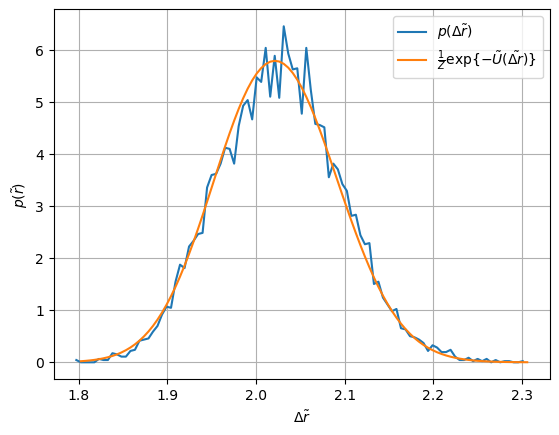

In [217]:
#single simulation
mobility = 0.00005
steps = 50000

parameter = (0.25, 2.08, 10)
#parameter = (0, 0, 20)

eps = parameter[0]
q = parameter[1]
n_beeds = parameter[2]

p1 = Polymer(mobility=mobility, epsilon_LJ=eps, q_beed=q)
# p1 = Polymer(n_beeds=n_beeds, mobility=mobility)
p1.create_chain(N=n_beeds)

t1 = time()
p1.simulate(steps, stride=50)
t2 = time()

print("simulation time")
print(f"{(t2-t1)//60:.0f}:{(t2-t1)%60:2.0f} min")

#p1.save_traj_gro()    

#p1.get_CM_MSD(plot=True)
p1.plot_distance_distribution()


In [5]:
# load traj into Polymer
#single simulation
mobility = 0.00005
steps = 30000
n_beeds = 50

fname = "./trajectories/traj_50beads_500000steps_0.000050mu_50stride.gro"

p = Polymer(n_beeds=n_beeds, mobility=mobility)
p.load_traj_gro(fname=fname, overwrite=True)
#p.plot_distance_distribution()



In [4]:
# test copying of edges

box_length = 10 # box length
cutoff = 1  # interaction cutoff
n = 5 # number of particles

positions = np.random.randint(0, 12, (n, 3))

positions = pbc(positions, box_length)
print(positions)

indices = np.arange(len(positions)) # (0, 1, ..., n-1)

# 3d logical lists
L_left = positions < cutoff
L_right = positions > (box_length-cutoff)

# create edges arrays and edges_idx arrays
# for this the cubical system needs to be copied 
# faces
# edges
# corners

#idexes all atoms inside the inner edge
L_in = np.logical_or(np.sum(L_left, axis=1, dtype=bool), np.sum(L_right, axis=1, dtype=bool))

edges_in = positions[L_in]
edges_in_indices = indices[L_in]

# for outer edges copy system needs to be copied 26 times
shifts = np.array(((box_length,   0,           0),
                  (0,            box_length,  0),
                  (0,            0,           box_length),
                  (box_length,   box_length,  0),
                  (box_length,   0,           box_length),
                  (0,            box_length,  box_length),
                  (box_length,   box_length,  box_length),
                  (-box_length,  0,           0),
                  (0,           -box_length,  0),
                  (0,            0,          -box_length),
                  (-box_length,  box_length,  0),
                  (-box_length,  0,           box_length),
                  (0,           -box_length,  box_length),
                  (box_length,  -box_length,  0),
                  (box_length,   0,          -box_length),
                  (0,            box_length, -box_length),
                  (-box_length, -box_length,  0),
                  (-box_length,  0,          -box_length),
                  (0,           -box_length, -box_length),
                  (-box_length,  box_length,  box_length),
                  (box_length,  -box_length,  box_length),
                  (box_length,   box_length, -box_length),
                  (-box_length, -box_length,  box_length),
                  (-box_length,  box_length, -box_length),
                  (box_length,  -box_length, -box_length),
                  (-box_length, -box_length, -box_length)))

edges_out = positions + shifts[0]
edges_out_indices = np.arange(len(positions))
for shift in shifts[1:]:
    edges_out = np.append(edges_out, positions+shift, axis=0)
    edges_out_indices = np.append(edges_out_indices, indices)
    
print(edges_out_indices)

# check which particles lie in the outer edge
L_left_out = np.logical_and((edges_out < 0), (edges_out >= -cutoff))
L_right_out = np.logical_and((edges_out >= box_length), (edges_out < (box_length+cutoff)))
L_out = np.logical_or(np.sum(L_left_out, axis=1, dtype=bool), np.sum(L_right_out, axis=1, dtype=bool))

edges_out = edges_out[L_out]
edges_out_indices = edges_out_indices[L_out]

# create distance matrix for edges in/out
n_in = len(edges_in_indices)
n_out = len(edges_out_indices)

A = np.tile(edges_in, (n_out, 1, 1)) # repeats vector along third dimension len(b) times
B = np.reshape(np.repeat(edges_out, n_in, 0), (n_out, n_in, 3)) # does the same but "flipped"


directions_edges = A - B
distances_edges = np.linalg.norm(directions_edges, axis=2)

idx_in, idx_out = np.meshgrid(edges_in_indices, edges_out_indices)
idx_table_edges = np.append([idx_in], [idx_out], axis=0)

# TODO test edge cases lol

[[7 1 0]
 [3 5 6]
 [0 7 3]
 [9 8 1]
 [9 2 1]]
[0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1
 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3
 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0
 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]


In [120]:
def dist_dir_edges(positions, box_length, cutoff):
    """
    This uses the concept of the "inner-" and "outer edge". Particles are defined to lie in the inner edge, 
    when thethey are inside the box within the a cutoff distance to the edge of the box. Similarly outer edges
    are particles, that are outside of the box within a cutoff distance to the box edge.
    If there are N particles in the inner edge and M particles in the outer edge, then this function returns
    a NxM distance array, a NxMx3 directions array and a 2xNxM table of indices.
    """
    
    n = len(positions)

    # positions = np.random.randint(0, 12, (n, 3))
    
    # positions = pbc(positions, box_length) # TODO is this really necessary here in the function???

    indices = np.arange(n) # (0, 1, ..., n-1)

    # 3d logical lists
    L_left = positions < cutoff
    L_right = positions > (box_length-cutoff)

    #indexes all atoms inside the inner edge
    L_in = np.logical_or(np.sum(L_left, axis=1, dtype=bool), np.sum(L_right, axis=1, dtype=bool))

    edges_in = positions[L_in]
    edges_in_indices = indices[L_in]

    # TODO only continue if there are edges_in !!!
    
    # TODO do this outside and create a self.shifts array
    
    # for outer edges cubic system needs to be copied 26 times
    shifts = np.array(( (box_length,   0,           0),
                        (0,            box_length,  0),
                        (0,            0,           box_length),
                        (box_length,   box_length,  0),
                        (box_length,   0,           box_length),
                        (0,            box_length,  box_length),
                        (box_length,   box_length,  box_length),
                        (-box_length,  0,           0),
                        (0,           -box_length,  0),
                        (0,            0,          -box_length),
                        (-box_length,  box_length,  0),
                        (-box_length,  0,           box_length),
                        (0,           -box_length,  box_length),
                        (box_length,  -box_length,  0),
                        (box_length,   0,          -box_length),
                        (0,            box_length, -box_length),
                        (-box_length, -box_length,  0),
                        (-box_length,  0,          -box_length),
                        (0,           -box_length, -box_length),
                        (-box_length,  box_length,  box_length),
                        (box_length,  -box_length,  box_length),
                        (box_length,   box_length, -box_length),
                        (-box_length, -box_length,  box_length),
                        (-box_length,  box_length, -box_length),
                        (box_length,  -box_length, -box_length),
                        (-box_length, -box_length, -box_length)))

    # shift system and append to array
    edges_out = positions + shifts[0]
    edges_out_indices = np.arange(len(positions))
    for shift in shifts[1:]:
        edges_out = np.append(edges_out, positions+shift, axis=0)
        edges_out_indices = np.append(edges_out_indices, indices)

    # check which particles lie in the outer edge
    L_left_out = np.logical_and((edges_out < 0), (edges_out >= -cutoff))
    L_right_out = np.logical_and((edges_out >= box_length), (edges_out < (box_length+cutoff)))
    L_out = np.logical_or(np.sum(L_left_out, axis=1, dtype=bool), np.sum(L_right_out, axis=1, dtype=bool))

    edges_out = edges_out[L_out]
    edges_out_indices = edges_out_indices[L_out]
    
    # TODO only continue if there are edges_out

    # create distance matrix for edges in/out
    n_in = len(edges_in_indices)
    n_out = len(edges_out_indices)

    # create mesh of vectors
    A = np.tile(edges_in, (n_out, 1, 1)) # repeats vector along third dimension len(b) times
    B = np.reshape(np.repeat(edges_out, n_in, 0), (n_out, n_in, 3)) # does the same but "flipped"

    directions_edges = B-A
    distances_edges = np.linalg.norm(directions_edges, axis=2)

    idx_in, idx_out = np.meshgrid(edges_in_indices, edges_out_indices)
    idx_table_edges = np.append([idx_in], [idx_out], axis=0)
    
    # only output distances smaller than  cutoff
    L_edges = distances_edges < cutoff

    dirs = directions_edges[L_edges]
    dists = distances_edges[L_edges]
    idxs = idx_table_edges[:, L_edges]
    
    return dirs, dists, idxs.T

In [54]:
# test edge cases for pbc
# NOTE it works!
positions = np.array(((0.1, 0.1, 0.1),
                      (0.1, 0.1, 9.9),
                      (0.1, 9.9, 0.1),
                      (9.9, 0.1, 0.1),
                      (0.1, 9.9, 9.9),
                      (9.9, 0.1, 9.9),
                      (9.9, 9.9, 0.1),
                      (9.9, 9.9, 9.9)))
box_length = 10
cutoff = 1
positions = pbc(positions, box_length)


t1 = time()
dirs, dists, idxs = dist_dir_edges(positions, box_length, cutoff)
t2 = time()


print(np.shape(dirs))
print(np.shape(dists))
print(np.shape(idxs))


print("dirs")
print(dirs)
print("dists")
print(dists)
print("idxs")
print(idxs)
print("positions")
print(positions)

L_0 = idxs[0, :] == 7
print("directios w.r.t. paricle 7")
print(dirs[L_0])
print("idxs 7")
print(idxs[:, L_0])


(56, 3)
(56,)
(2, 56)
dirs
[[ 0.2  0.   0. ]
 [ 0.2  0.   0. ]
 [ 0.2  0.   0. ]
 [ 0.2  0.   0. ]
 [ 0.   0.2  0. ]
 [ 0.   0.2  0. ]
 [ 0.   0.2  0. ]
 [ 0.   0.2  0. ]
 [ 0.   0.   0.2]
 [ 0.   0.   0.2]
 [ 0.   0.   0.2]
 [ 0.   0.   0.2]
 [ 0.2  0.2  0. ]
 [ 0.2  0.2  0. ]
 [ 0.2  0.   0.2]
 [ 0.2  0.   0.2]
 [ 0.   0.2  0.2]
 [ 0.   0.2  0.2]
 [ 0.2  0.2  0.2]
 [-0.2  0.   0. ]
 [-0.2  0.   0. ]
 [-0.2  0.   0. ]
 [-0.2  0.   0. ]
 [ 0.  -0.2  0. ]
 [ 0.  -0.2  0. ]
 [ 0.  -0.2  0. ]
 [ 0.  -0.2  0. ]
 [ 0.   0.  -0.2]
 [ 0.   0.  -0.2]
 [ 0.   0.  -0.2]
 [ 0.   0.  -0.2]
 [-0.2  0.2  0. ]
 [-0.2  0.2  0. ]
 [-0.2  0.   0.2]
 [-0.2  0.   0.2]
 [ 0.  -0.2  0.2]
 [ 0.  -0.2  0.2]
 [ 0.2 -0.2  0. ]
 [ 0.2 -0.2  0. ]
 [ 0.2  0.  -0.2]
 [ 0.2  0.  -0.2]
 [ 0.   0.2 -0.2]
 [ 0.   0.2 -0.2]
 [-0.2 -0.2  0. ]
 [-0.2 -0.2  0. ]
 [-0.2  0.  -0.2]
 [-0.2  0.  -0.2]
 [ 0.  -0.2 -0.2]
 [ 0.  -0.2 -0.2]
 [-0.2  0.2  0.2]
 [ 0.2 -0.2  0.2]
 [ 0.2  0.2 -0.2]
 [-0.2 -0.2  0.2]
 [-0.2  0.2 -0.2]
 

In [121]:
def dist_dir_box(positions, box_length, cutoff):
    
    # TODO could be faster by only calculation triu matrix
    
    n = len(positions)
    
    # TODO do this outside of function
    idx_table = np.zeros((2, n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            idx_table[0, i, j] = i
            idx_table[1, i, j] = j


    # make 3d verion of meshgrid
    r_left = np.tile(positions, (n, 1, 1)) # repeats vector along third dimension len(a) times
    r_right = np.reshape(np.repeat(positions, n, 0), (n, n, 3)) # does the same but "flipped"

    directions = r_left - r_right # this is right considering the mesh method. dir[i, j] = r_j - r_i
    distances = np.linalg.norm(directions, axis=2)
    
    # use cutoff to index values
    distances += cutoff*np.eye(n) # add cutoff to disregard same atoms

    L_box = distances < cutoff # NOTE the "<" is important, because if it was "<=" the diagonal values would be included
    
    dirs = directions[L_box]
    dists = distances[L_box]
    idxs = idx_table[:, L_box]
    
    return dirs, dists, idxs.T

[[2 1 8]
 [6 6 8]
 [8 5 9]
 [6 7 7]
 [4 0 9]]
[[0 1 1 2 2 3 3 4]
 [4 2 3 1 3 1 2 0]]
[[3 4]
 [4 3]]
[2.44948974 2.44948974 1.41421356 2.44948974 3.46410162 1.41421356
 3.46410162 2.44948974]


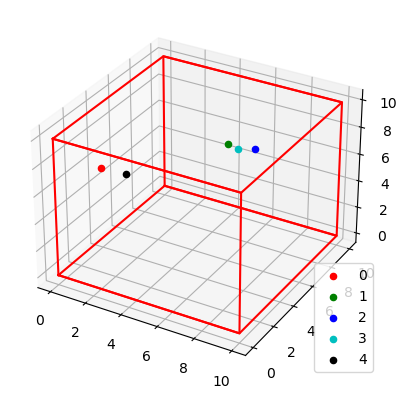

In [81]:
# test pbc

positions = np.random.randint(0, 12, (n, 3))


l_box = 10 # box length
rc = 4.5  # interaction cutoff
n = 5 # number of particles

# apply pbc
positions = pbc(positions, box_length)

# calculate dist dir inside box w.r.t. cutoff
directions, distances, idx_table = dist_dir_box(positions, l_box, rc)

# calculate dist dir for box edge w.r.t. cutoff
directions_edges, distances_edges, idx_table_edges = dist_dir_edges(positions, l_box, rc)

print(positions)

#print(np.shape(directions))
print(idx_table)
#print(directions)
print(idx_table_edges)

print(distances)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors = ('r', 'g', 'b', 'c', 'k')
for i in range(n):
    ax.scatter(positions[i, 0],positions[i, 1], positions[i, 2], c=colors[i], label=f"{i}")
xy = np.array(((0,0),
                (l_box, 0),
                (l_box, l_box),
                (0, l_box),
                (0,0)))

ax.legend()
 

ax.plot(xy[:, 0], xy[:, 1], zs=0, zdir='z', c="r")
ax.plot(xy[:, 0], xy[:, 1], zs=l_box, zdir='z', c="r")
ax.plot(xy[:, 0], xy[:, 1], zs=0, zdir='y', c="r")
ax.plot(xy[:, 0], xy[:, 1], zs=l_box, zdir='y', c="r")



In [31]:
def force_NearestNeighbours(distances, 
                            directions, 
                            idxs, 
                            bonds, 
                            forces, 
                            force_constant_nn = 100, 
                            r0_beeds = 2):
    """
    harmonice nearest neighhbour interactions
    """
    # loop through index list and see if any tuple corresponds to bond
    # NOTE if there were more NN forces in the system this should be done outside of the function
    L = list(())
    for idx in idxs:
        if np.any(np.logical_and(idx[0] == bonds[:, 0], idx[1] == bonds[:, 1])):
            L.append(True)
        else:
            L.append(False)
            
    idxs = idxs[L]
    distances = distances[L]
    directions = directions[L]
    
    # calculate the force of every bond at once
    forces_temp = 2*force_constant_nn*(1-r0_beeds/distances.reshape(-1,1))*directions

    for i, force in zip(idxs[:, 0], forces_temp):
        forces[i, :] += force
    
    return forces

def force_LennardJones_cutoff(distances, 
                              directions, 
                              idxs, 
                              forces,
                              r_beed = 1,
                              epsilon_LJ = 0.25, 
                              sigma_LJ = 2):
    """
    LJ interactions using a cutoff
    """
    
    cutoff = 2*r_beed
    
    L = distances < cutoff
    
    idxs = idxs[L]
    distances = distances[L].reshape(-1, 1)
    directions = directions[L]
    
    forces_temp = 4*epsilon_LJ*(-12*sigma_LJ**12/distances**14 + 6*sigma_LJ**7/distances**8)*directions

    for i, force in zip(idxs[:, 0], forces_temp):
        forces[i, :] += force
        
    return forces

def force_Debye(distances, 
                directions, 
                idxs, 
                forces,
                A_debye,
                B_debye):
        """
        non bonded interaction (debye screening)
        """
        distances = distances.reshape(-1,1)
        # since the debye cutoff is used for the dist/dir cutoff the distances dont have to be checked
        forces_temp = -A_debye*(1+B_debye*distances)*np.exp(-B_debye*distances)*directions/distances**3
        
        for i, force in zip(idxs[:, 0], forces_temp):
            forces[i, :] += force
        
        return forces

def create_test_chain(n_beeds = 10,
                      r0_beeds = 2,
                      sigma: float = 0.05):
    """
    Create linear chain along specified axis, centered in the origin.
    The positions of the linear chain are deviated wit a gaussian noise 
    of standard deviation sigma.
    The get_bonds() method is called here automatically.
    
    Arguments:
        sigma (float): standard deviation for the displacement
        axis (int): specify on which axis the chain lies on (0,1,2) -> (x,y,z)
    """
    
    positions = np.zeros((n_beeds, 3))
    
    for k in range(n_beeds):
        positions[k, 0] = k*r0_beeds
    
    #center chain around 0
    if n_beeds != 1:
        positions[:, 0] -= r0_beeds*(n_beeds-1)/2
    
    positions[:, 1] += 2*n
    positions[:, 2] += 2*n
    
    # create index list
    indices = np.arange(n_beeds)
    
    # create list of bond tuples
    bonds =list(())
    bonds.append((0,1))
    for k in range(1, n_beeds-1):
        bonds.append((k, k-1))
        bonds.append((k, k+1))
    bonds.append((n_beeds-1, n_beeds-2))
    
    bonds = np.array(bonds)
    
    # create nxn index table 
    idx_table = np.zeros((2, n_beeds, n_beeds), dtype=int)
    for i in range(n_beeds):
        for j in range(n_beeds):
            idx_table[0, i, j] = i
            idx_table[1, i, j] = j
    
    # to test forces
    positions += np.random.randn(n_beeds, 3)*sigma
    
    return positions, bonds

def plot_box(positions, l_box):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    for i in range(len(positions)):
        ax.scatter(positions[i, 0],positions[i, 1], positions[i, 2])
    
    xy = np.array(((0,0),
                    (l_box, 0),
                    (l_box, l_box),
                    (0, l_box),
                    (0,0)))

    

    ax.plot(xy[:, 0], xy[:, 1], zs=0, zdir='z', c="r")
    ax.plot(xy[:, 0], xy[:, 1], zs=l_box, zdir='z', c="r")
    ax.plot(xy[:, 0], xy[:, 1], zs=0, zdir='y', c="r")
    ax.plot(xy[:, 0], xy[:, 1], zs=l_box, zdir='y', c="r")
    


In [180]:
# test forces using arrays instead of loops
# compare to old force calculations

n = 10

p = Polymer(n_beeds=n)
p.create_test_chain(centered=True)

#positions, bonds = create_test_chain(n_beeds=n)
positions = p.positions
bonds = p.bonds


l_box = p.box_length # box length
rc = p.cutoff_debye  # interaction cutoff
# plot_box(positions, l_box)

# apply pbc
positions = pbc(positions, l_box)
#plot_box(positions, l_box)

#plot_box(positions, l_box)

# calculate dist dir inside box w.r.t. cutoff
directions, distances, idx_table = dist_dir_box(positions, l_box, rc)

# calculate dist dir for box edge w.r.t. cutoff
directions_edges, distances_edges, idx_table_edges = dist_dir_edges(positions, l_box, rc)

# combine dist/dir to one list
directions = np.append(directions, directions_edges, axis=0)
distances = np.append(distances, distances_edges, axis=0)
idx_table = np.append(idx_table, idx_table_edges, axis=0)

# initialize forces
forces = np.zeros((n, 3))
# print(idx_table.T)
# print(bonds)
forces = force_NearestNeighbours(distances, 
                                directions, 
                                idx_table, 
                                bonds, 
                                forces)
print("NN")
print(forces)
forces = np.zeros((n, 3))
forces = force_LennardJones_cutoff(distances, 
                              directions, 
                              idx_table, 
                              forces)
print("LJ")
print(forces)
forces = np.zeros((n, 3))
force_Debye(distances, 
                directions, 
                idx_table, 
                forces,
                p.A_debye,
                p.B_debye)
print("Deb")
print(forces)
print("reference")
p.get_forces_test()



NN
[[-7.02857040e+00 -5.57725237e-01 -7.52686932e-02]
 [-1.03355088e+00  7.69372309e-01  4.09909688e-01]
 [ 7.40433797e+00 -1.60237854e-01 -3.35303028e-01]
 [ 1.82329669e+01  3.42999196e-01  8.11591392e-01]
 [-2.19062293e+01 -5.73550559e-01 -6.53970649e-01]
 [-1.01119521e+00  1.78648626e-01  4.64825216e-02]
 [ 1.72304604e+00  1.72670789e-01 -4.06284586e-01]
 [ 1.32735275e+01  6.25724790e-01  2.33182834e-01]
 [-4.96958627e+00 -1.14942521e+00 -1.97645208e-02]
 [-4.68474638e+00  3.51523151e-01 -1.05749579e-02]]
LJ
[[-7.62799700e-01 -6.05290435e-02 -8.16879299e-03]
 [-1.36525962e-01  8.41381703e-02  4.54978313e-02]
 [ 8.39089812e-01 -1.89013788e-02 -3.73896634e-02]
 [ 6.02358507e-02 -4.70774793e-03  6.06250719e-05]
 [-4.37149671e-01 -1.80815291e-02  1.58424669e-02]
 [-1.16759444e-01  1.80303589e-02  5.25129394e-03]
 [ 1.95427498e-01  1.71053464e-02 -4.11854156e-02]
 [ 3.58481617e-01 -1.70541761e-02  2.00916548e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.000

In [9]:
for m in range(1, 10):
    print(m, np.round(np.sqrt(m)))

1 1.0
2 1.0
3 2.0
4 2.0
5 2.0
6 2.0
7 3.0
8 3.0
9 3.0


In [ ]:
# create box with M chains consisting of N atoms
def create_box(N=10, M=5, r0=2, L=None):

    if M == 1:
        # self.create_chain()
        return
    if L is None
        L = N*r0 # box length

    n_row = int(np.round(np.sqrt(M)))

    # check how many cols are needed
    n_col = 0
    while n_col*n_row < M:
        n_col += 1

    d_row = L/(n_row+1)
    d_col = L/(n_col+1)

    positions = np.zeros((M*N, 3))
    bonds = list(())

    particle_idx = 0
    # make centered mesh
    for i in range(n_col):
        for j in range(n_row):
            if particle_idx == N*M:
                break
            # create chain
            n = 0
            for k in range(particle_idx, N+particle_idx):
                positions[k, (i+1)%2] = (L-r0*(N-1))/2 + n*r0
                positions[k, i%2] = j*d_row + d_row 
                positions[k, 2] = i*d_col + d_col 
                n += 1
            # add bonds to bond list
            bonds.append((particle_idx, particle_idx+1))
            for k in range(N-2):
                particle_idx += 1
                bonds.append((particle_idx, particle_idx-1))
                bonds.append((particle_idx, particle_idx+1))
            particle_idx += 1
            bonds.append((particle_idx, particle_idx-1))
            particle_idx += 1
    
    bonds = np.array(bonds)
    
    return

6.666666666666667 2
5.0 3
20
[[ 6.66666667  1.          5.        ]
 [ 6.66666667  3.          5.        ]
 [ 6.66666667  5.          5.        ]
 [ 6.66666667  7.          5.        ]
 [ 6.66666667  9.          5.        ]
 [ 6.66666667 11.          5.        ]
 [ 6.66666667 13.          5.        ]
 [ 6.66666667 15.          5.        ]
 [ 6.66666667 17.          5.        ]
 [ 6.66666667 19.          5.        ]
 [13.33333333  1.          5.        ]
 [13.33333333  3.          5.        ]
 [13.33333333  5.          5.        ]
 [13.33333333  7.          5.        ]
 [13.33333333  9.          5.        ]
 [13.33333333 11.          5.        ]
 [13.33333333 13.          5.        ]
 [13.33333333 15.          5.        ]
 [13.33333333 17.          5.        ]
 [13.33333333 19.          5.        ]
 [ 1.          6.66666667 10.        ]
 [ 3.          6.66666667 10.        ]
 [ 5.          6.66666667 10.        ]
 [ 7.          6.66666667 10.        ]
 [ 9.          6.66666667 10.      

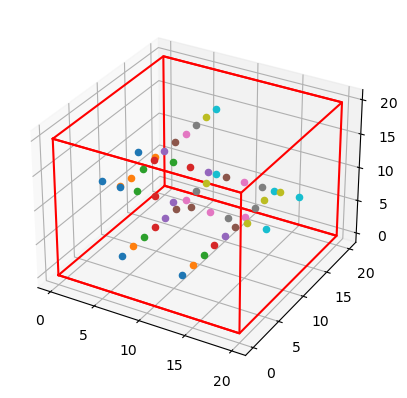

In [51]:
# create box with M chains consisting of N atoms

N = 10 # atoms/chain
M = 5 # chains

r0 = 2

if M == 1:
    # self.create_chain()
    # return
    M = 1 

L = N*r0 # box length

n_row = int(np.round(np.sqrt(M)))

# check how many cols are needed
n_col = 0
while n_col*n_row < M:
    n_col += 1

d_row = L/(n_row+1)
d_col = L/(n_col+1)

positions = np.zeros((M*N, 3))
bonds = list(())

particle_idx = 0
# make centered mesh
for i in range(n_col):
    for j in range(n_row):
        if particle_idx == N*M:
            break
        # create chain
        n = 0
        for k in range(particle_idx, N+particle_idx):
            positions[k, (i+1)%2] = (L-r0*(N-1))/2 + n*r0
            positions[k, i%2] = j*d_row + d_row 
            positions[k, 2] = i*d_col + d_col 
            n += 1
        # add bonds to bond list
        bonds.append((particle_idx, particle_idx+1))
        for k in range(N-2):
            particle_idx += 1
            bonds.append((particle_idx, particle_idx-1))
            bonds.append((particle_idx, particle_idx+1))
        particle_idx += 1
        bonds.append((particle_idx, particle_idx-1))
        particle_idx += 1
        
        



plot_box(positions, L)

print(d_row, n_row)
print(d_col, n_col)
print(L)

print(positions)



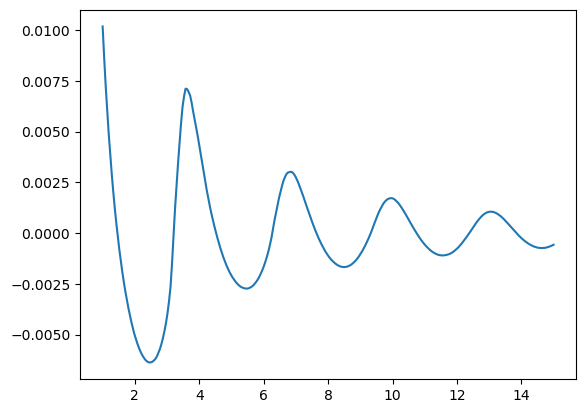

In [ ]:
q = np.linspace(1, 15, 300)

p.get_structure_factor(q=q)

plt.figure()
plt.plot(q, p.structure_factor)
#plt.loglog()
plt.show()

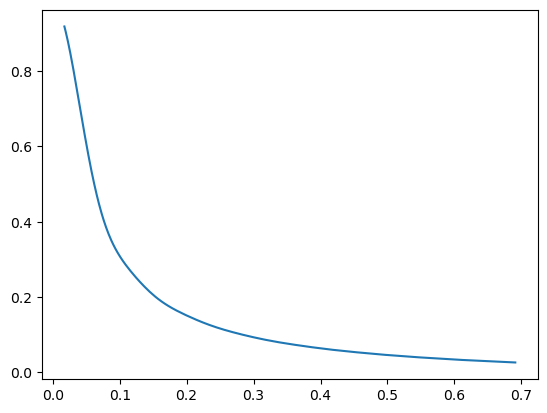

In [34]:
#make q dependent on lambda
lam = np.linspace(0.5, 20, 300) # wavelength in reduced units
n = 1.1 # refractive index
theta = 0.05 #scattering angle
q = 4*np.pi*n/lam * np.sin(theta/2)

p.get_structure_factor(q=q)

plt.figure()
plt.plot(q, p.structure_factor)
plt.show()

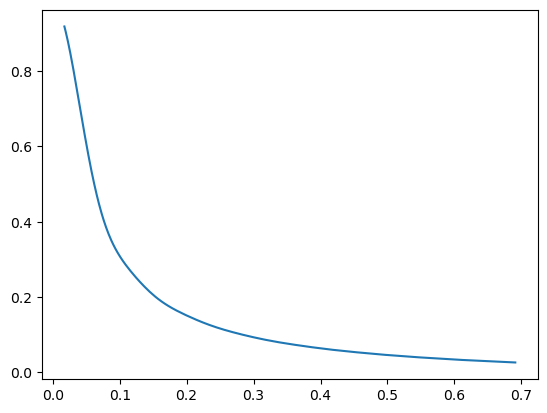

In [40]:
plt.figure()
plt.plot(q, p.structure_factor)
#plt.plot(q,0.1/q)
#plt.loglog()
plt.show()

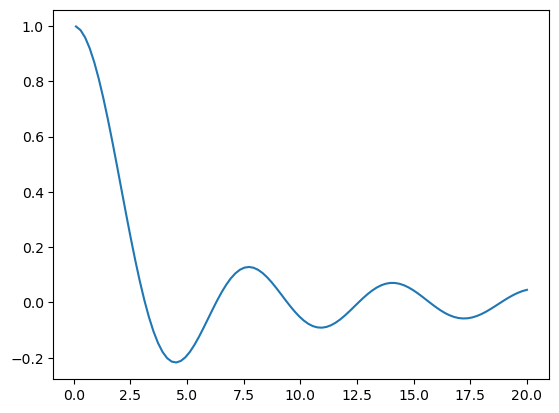

In [33]:
x = np.linspace(0.1, 20, 100)

plt.plot(x, np.sin(x)/x)

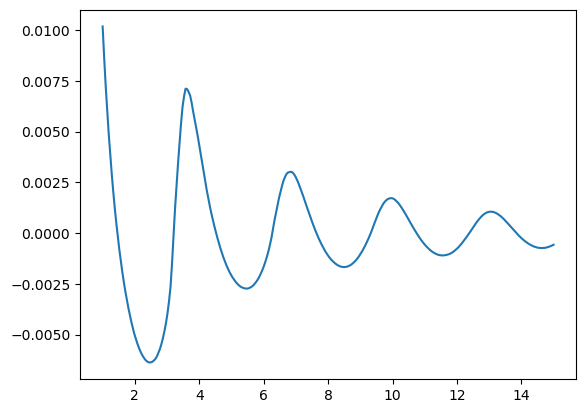

In [26]:
q = np.linspace(1, 15, 300)
p.structure_factor = np.zeros(len(q))
               
for frame in p.trajectory:
    for i in range(p.n_beeds-1):
        for j in range(i+1, p.n_beeds):
            r = frame[j] - frame[i]
            qr = q*np.sqrt(np.dot(r, r))
            p.structure_factor += np.sin(qr)/qr

#factor 2 because of double sum reduction from i,j to i<j
p.structure_factor = p.structure_factor*2/p.n_beeds**2/len(p.trajectory)
plt.figure()
plt.plot(q, p.structure_factor)
plt.show()

In [30]:
mobility = 0.0005
steps = 1000


parameter_list = ((0.25, 2.08, 10))
for k, params in enumerate(parameter_list):
    # p1 = Polymer(n_beeds=n_beeds, mobility=mobility, q_beed=0, epsilon_LJ=0)
    
    eps = params[0]
    q = params[1]
    n_beeds = params[2]
    
    p1 = Polymer(n_beeds=n_beeds, mobility=mobility, epsilon_LJ=eps, q_beed=q)
    p1.create_chain(axis=1)

    t1 = time()
    p1.simulate(steps)
    t2 = time()
    print("simulation time")
    print(f"{(t2-t1)//60:.0f}:{(t2-t1)%60:2.0f} min")
    
    print("Parameters:", params)
    
    p1.save_traj_gro()    
    
    #p1.get_CM_MSD(plot=True)
    p1.get_CM_MSD(plot=True)
    p1.plot_distance_distribution()


TypeError: 'float' object is not subscriptable

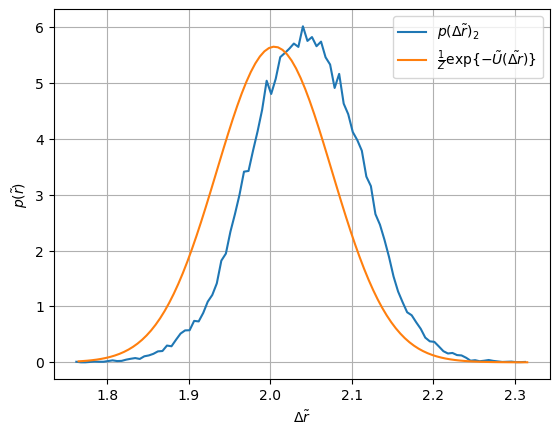

In [27]:
p1.save_traj_gro()
p1.plot_distance_distribution()

In [ ]:
# calculate distribution of distances between two neighbouring beeds
n_beeds = 20
distances_nn = list(())
diff = 0 # number of beeds on the two ends of the chain that shouldnt be included
for frame in trajectory.xyz:
    distances_nn.append(np.sqrt(np.sum((frame[diff:n_beeds-1-diff] - frame[1+diff:n_beeds-diff])**2, axis=1)))

distances_nn = np.array(distances_nn).ravel()

print(np.min(distances_nn))
print(np.max(distances_nn))

n_bins = 200
bin_interval = (np.min(distances_nn), np.max(distances_nn))
#bin_interval = (1.0, 3.5)

histogram_nn, edges_nn = np.histogram(distances_nn, bins=n_bins, range=bin_interval, density=True)

In [ ]:
msd_tid = tid.msd(traj_cm)
msd_tid_x = tid.msd(traj_cm[:,0])
msd_tid_y = tid.msd(traj_cm[:,1])
msd_tid_z = tid.msd(traj_cm[:,2])

t = np.arange(n_frames)

plt.figure()
#plt.loglog(t[1:], msd_fast, label=r"$\langle \Delta\tilde{r}^2\rangle$")
#plt.loglog(t[1:], msd_x, label=r"$\langle \Delta\tilde{r}_x^2\rangle$")
#plt.loglog(t[1:], msd_y, label=r"$\langle \Delta\tilde{r}_y^2\rangle$")
#plt.loglog(t[1:], msd_z, label=r"$\langle \Delta\tilde{r}_z^2\rangle$")
#plt.loglog(t[1:], msd_x+msd_y+msd_z, label="1+2+3")
plt.loglog(t[1:], 2*t[1:]*mobility, label=r"$2t\tilde{\mu}_0$", linestyle="--")
plt.loglog(t[1:], 6*t[1:]*mobility, label=r"$6t\tilde{\mu}_0$", linestyle="--")
#plt.loglog(t[1:], msd_mdt, label="mdtraj")
plt.loglog(t[1:], msd_tid[1:]*n_beeds, label="tidyn")
plt.loglog(t[1:], msd_tid_x[1:]*n_beeds, label="tidyn x")
plt.loglog(t[1:], msd_tid_y[1:]*n_beeds, label="tidyn y")
plt.loglog(t[1:], msd_tid_z[1:]*n_beeds, label="tidyn z")
plt.xlabel(r"$t/\Delta t$")
plt.ylabel("MSD")
plt.legend()
plt.show()

In [ ]:

def analytical_potential(r, polymer):
    K = polymer.force_constant_nn
    r0 = polymer.r0_beeds
    epsilon = polymer.epsilon_LJ 
    sigma = polymer.sigma_LJ
    q = polymer.q_beed
    lB = polymer.lB_debye
    L_s = 1/(38.46153*polymer.c_S)
    
    u_nn = K*(r-r0)**2
    u_LJ = 4*epsilon*(sigma**12/r**12 - sigma**7/r**6 + 1)
    u_Deb = q**2*lB*np.exp(-L_s*r)/r
   
    return u_nn #+ u_LJ + u_Deb

In [16]:
# process trajectory using mdtraj

fname_top = f'polymer_{n_beeds:d}_beeds.pdb'
fname_traj = f"traj_{n_beeds:d}beeds_{steps:d}frames_{mobility:.5f}mu.gro"

# save trajectory in mdtraj to create .gro simulation trajectory
topology = md.load(fname_top).topology
trajectory = md.Trajectory(p1.trajectory, topology)

# save as gromacs file
trajectory.save_gro(filename=fname_traj)

# alternatively load traj from saved files
# trajectory = md.load(fname_traj, top=fname_top)

In [15]:
# alternatively load traj from saved files
n_beeds = 20
steps = 100000
mobility = 0.0005


fname_top = f'topologies/polymer_{n_beeds:d}_beeds.pdb'
fname_traj = f"trajectories/traj_{n_beeds:d}beeds_{steps:d}frames_{mobility:.5f}mu_onlyHarmonic.gro"

trajectory = md.load(fname_traj, top=fname_top)


list

In [79]:
# calculate radius of gyration 

deviation_cm = np.zeros((p1.n_beeds))
for frame, r_cm in zip(p1.trajectory, traj_cm):
    deviation_cm += np.sum((frame-r_cm)**2, axis=1)

Rg = np.sqrt(np.sum(deviation_cm/n_frames)/p1.n_beeds)

print(Rg)
    

6.265390878155055
